In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
import glob
import torch
from torch.utils.data import DataLoader

import sys

sys.path.append("../filters-models")
from Convolutional_Mormyromast import ConvMormyromast
from lfp_response_dataset import create_train_and_validation_datasets

# Stimuli

## Example stimuli delivered

In [2]:
lfp_data = pd.read_pickle('../data/lfp-abby/processed/trial_averages.pkl')
select_stimuli = np.vstack(lfp_data[(lfp_data["fish_id"] == "fish_01") & (lfp_data["zone"] == "mz")]["waveform"]).T
base_stimulus = lfp_data["base_waveform"].iloc[0]
sampling_rate = lfp_data["stimulus_sampling_rate"].iloc[0]

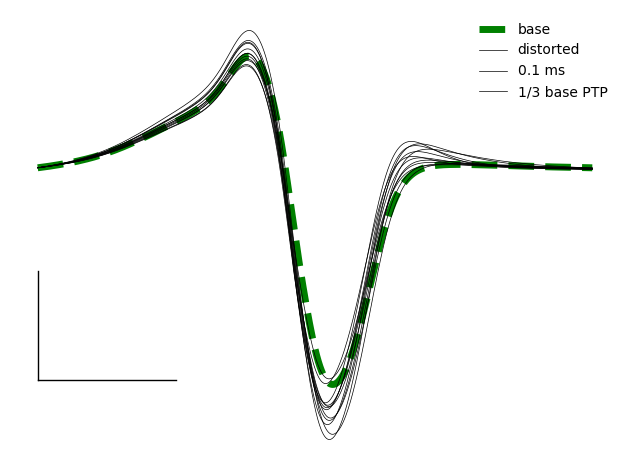

In [3]:
plt.figure()
plt.plot(base_stimulus, "green", ls="--", lw=5)
plt.plot(select_stimuli[:, ::20], "k", lw=0.5)
plt.plot([0, 0.1e-3 * sampling_rate], [-1, -1], "k", lw=1)
plt.plot([0, 0], [-1, -1 + base_stimulus.ptp()/3], "k", lw=1)
plt.legend(["base", "distorted", "0.1 ms", "1/3 base PTP"], loc=1, frameon=False)
plt.xticks([])
plt.yticks([])
plt.box(False)
plt.tight_layout()
plt.savefig("./panels/example_stimuli.svg")
plt.show()

## Delivered vs. recorded stimuli

In [4]:
stimulus_delivery_data = pd.read_pickle('../data/stimulus-delivery-nate/processed/delivered-vs-recorded.pkl')

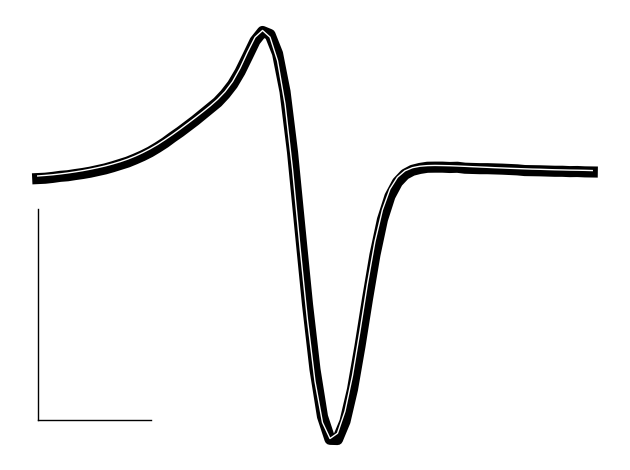

In [5]:
id = 0

dfrow = stimulus_delivery_data.iloc[id]

plt.figure()
# plt.plot(dfrow["stimulus_time"]*1e3, dfrow["stimulus"], label="stimulus", color='k', lw=8)
plt.plot(dfrow["recording_digital_time"]*1e3, dfrow["recording_digital"], label="stimulus", color='k', lw=8)
plt.plot(dfrow["recording_real_time"]*1e3, dfrow["recording_real"], label="stimulus", color='w', lw=1)
# plt.plot(dfrow["stimulus_time"]*1e3, dfrow["recording_real_interpolated"], label="interpolated", color='w', lw=1)

plt.plot([0, 0.1], [-0.6, -0.6], "k", lw=1)
plt.plot([0, 0], [-0.6, -0.6 + base_stimulus.ptp()/3], "k", lw=1)
plt.xticks([])
plt.yticks([])
plt.box(False)
plt.tight_layout()
plt.savefig("./panels/delivered_vs_recorded_example.svg")
plt.show()

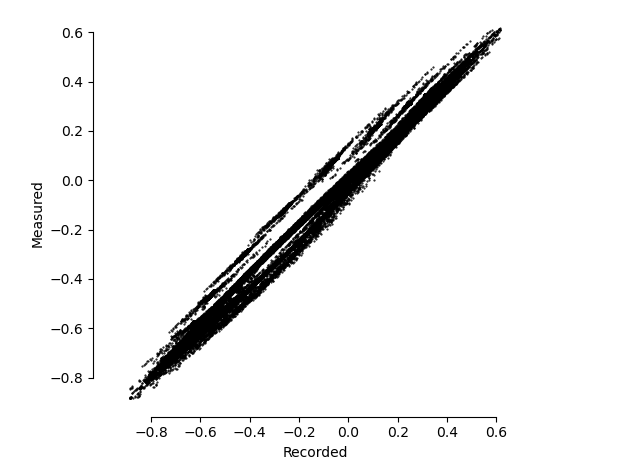

In [6]:
xs = np.hstack(stimulus_delivery_data["recording_digital"])
ys = np.hstack(stimulus_delivery_data["recording_real"])

fig = plt.figure()
plt.scatter(xs, ys, marker=".", color="k", s=1)
plt.axis("equal")
plt.xlabel("Recorded")
plt.ylabel("Measured")
sns.despine(offset={"left": -60}, trim=True)
plt.tight_layout()
plt.savefig("./panels/delivered_vs_recorded_scatter.svg")
# fig.set_size_inches(20, 20)
plt.savefig("./panels/delivered_vs_recorded_scatter.png", dpi=1000)
plt.show()

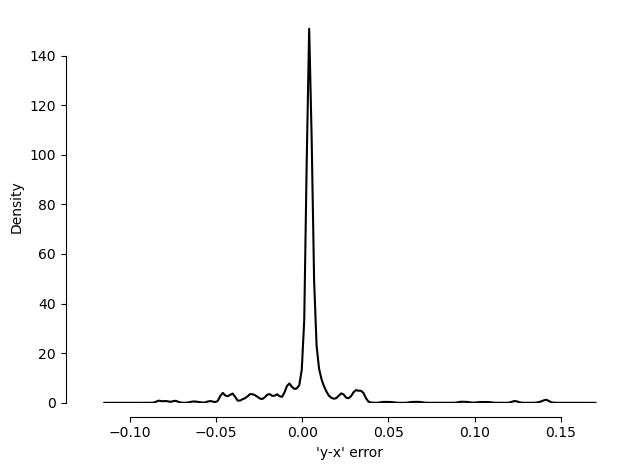

In [7]:
plt.figure()
sns.kdeplot(ys-xs, color='k')
sns.despine(offset=10, trim=True)
plt.xlabel("'y-x' error")
plt.tight_layout()
plt.savefig("./panels/delivered_vs_recorded_error-kdeplot.svg")
plt.show()

## LFP for MZ and DLZ

In [8]:
lfp_data = pd.read_pickle("../data/lfp-abby/processed/trial_averages.pkl")
lfp_data = lfp_data[lfp_data["fish_id"] == "fish_09"]
lfp_sampling_rate = lfp_data["lfp_sampling_rate"].iloc[0]
cmap = plt.cm.viridis  # type: ignore

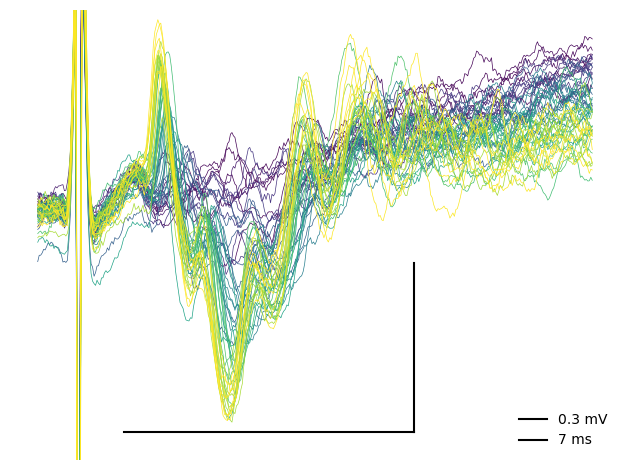

DLZ modulations: -0.142 to 0.000


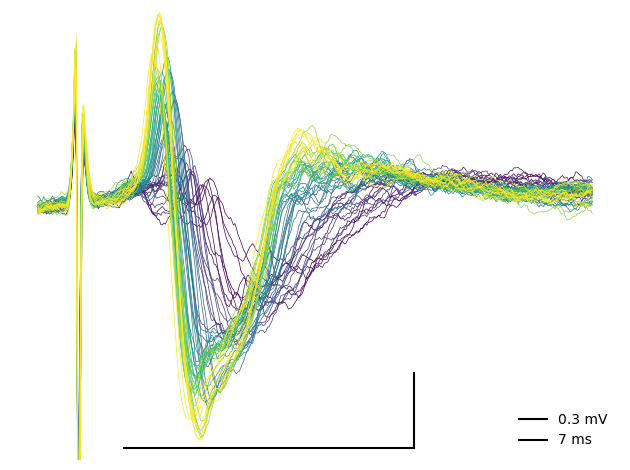

MZ modulations: -0.100 to 0.201


Empty DataFrame
Columns: []
Index: []

In [9]:
def plot_lfp_traces(dfgroup, cmap=cmap, lfp_sampling_rate=lfp_sampling_rate):
    plt.figure()
    zone = dfgroup["zone"].iloc[0]
    lfp_traces = np.vstack(
        dfgroup["lfp_trace"].apply(lambda x: x[0][7])
    )  # arbitrarily choose the 0th bout and 7th trial
    if zone == "dlz":
        modulations = np.hstack(dfgroup["stimulus_waveform_modulation_x"])
        plt.ylim(-0.4, 0.4)
        plt.plot(
            [30 + 8e-3 * lfp_sampling_rate, 30 + 8e-3 * lfp_sampling_rate],
            [-0.35, -0.05],
            "k",
            label="0.3 mV",
        )
        plt.plot([30 + 1e-3 * lfp_sampling_rate, 30 + 8e-3 * lfp_sampling_rate], [-0.35, -0.35], "k", label="7 ms")
    elif zone == "mz":
        modulations = np.hstack(dfgroup["stimulus_amplitude_modulation_x"])
        plt.plot(
            [30 + 8e-3 * lfp_sampling_rate, 30 + 8e-3 * lfp_sampling_rate],
            [-0.9, -0.6],
            "k",
            label="0.3 mV",
        )
        plt.plot([30 + 1e-3 * lfp_sampling_rate, 30 + 8e-3 * lfp_sampling_rate], [-0.9, -0.9], "k", label="7 ms")
        plt.ylim(-0.95, 0.85)
    sort_order = np.argsort(modulations)
    lfp_traces = lfp_traces[sort_order]
    modulations = modulations[sort_order]
    color_norm = mpl.colors.Normalize(vmin=modulations.min(), vmax=modulations.max())  # type: ignore
    for i in range(0, lfp_traces.shape[0], 1):
        plt.plot(lfp_traces[i][225:600], color=cmap(color_norm(modulations[i])), lw=0.5)
    plt.legend(loc=4, frameon=False)
    plt.xticks([])
    plt.yticks([])
    plt.box(False)
    plt.tight_layout()
    plt.savefig(f"./panels/lfp_traces_{zone}.svg")
    plt.show()
    print(f"{zone.upper()} modulations: {modulations.min():.3f} to {modulations.max():.3f}")


lfp_data.groupby("zone").apply(plot_lfp_traces)

## Alignment with PP and P/N

In [10]:
lfp_data = pd.read_pickle("../data/lfp-abby/processed/trial_averages.pkl")
cmap = plt.cm.plasma  # type: ignore

In [11]:
def plot_alignment_heatmap(dfgroup, cmap=cmap, inverse_arrow_length=0.1, arrow_width=0.5):
    fish_id = dfgroup["fish_id"].iloc[0]
    session_id = dfgroup["session_id"].iloc[0]
    zone = dfgroup["zone"].iloc[0]
    xs = np.hstack(dfgroup["stimulus_amplitude_modulation_x"]) * 100
    ys = np.hstack(dfgroup["stimulus_waveform_modulation_x"]) * 100
    responses = dfgroup["mean_lfp_response_modulation"] * 100
    reg = LinearRegression().fit(np.stack([xs, ys]).T, responses)
    grad_vec = reg.coef_ / np.linalg.norm(reg.coef_)

    color_norm = mpl.colors.Normalize(vmin=responses.min(), vmax=responses.max())  # type: ignore
    fig = plt.figure()
    plt.scatter(xs, ys, c=cmap(color_norm(responses)), s=100, marker="o")
    cbar = fig.colorbar(
        plt.cm.ScalarMappable(norm=color_norm, cmap=cmap),
        ax=plt.gca(),
        shrink=0.5,
        label="Mean LFP Response Modulation (%)",
    )
    sns.despine(ax=cbar.ax, left=False, bottom=False)
    x0, y0 = 0, 0
    if zone == "mz":
        x0 = plt.gca().get_xlim()[0]
        y0 = np.mean(plt.gca().get_ylim())
        inverse_arrow_length /= 2
    elif zone == "dlz":
        x0 = np.mean(plt.gca().get_xlim())
        y0 = plt.gca().get_ylim()[0]
    plt.arrow(
        x0,  # type: ignore
        y0,  # type: ignore
        grad_vec[0] / inverse_arrow_length,
        grad_vec[1] / inverse_arrow_length,
        facecolor="y",
        width=arrow_width,
        edgecolor="k",
        lw=1,
    )
    sns.despine(offset={"bottom": -35, "left": 10}, trim=True)
    plt.xlabel("Amplitude Modulation (%)")
    plt.ylabel("Waveform Modulation (%)")
    plt.axis("equal")
    plt.tight_layout()
    plt.title(f"{fish_id} {zone.upper()} {session_id}")
    plt.savefig(f"./panels/response_heatmap-{zone}-{fish_id}-{session_id}.svg")
    plt.show()
    return pd.Series(
        dict(
            grad_angle=np.arctan2(grad_vec[1], grad_vec[0]) * 360 / (2 * np.pi),
            grad_vec=grad_vec,
            reg_r2=reg.score(np.stack([xs, ys]).T, responses),
        )
    )

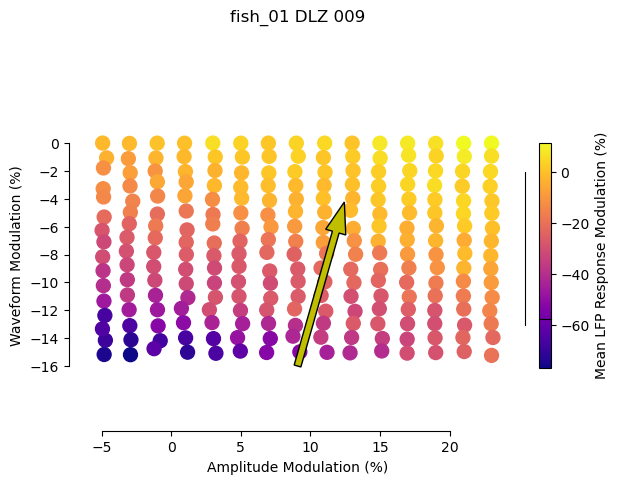

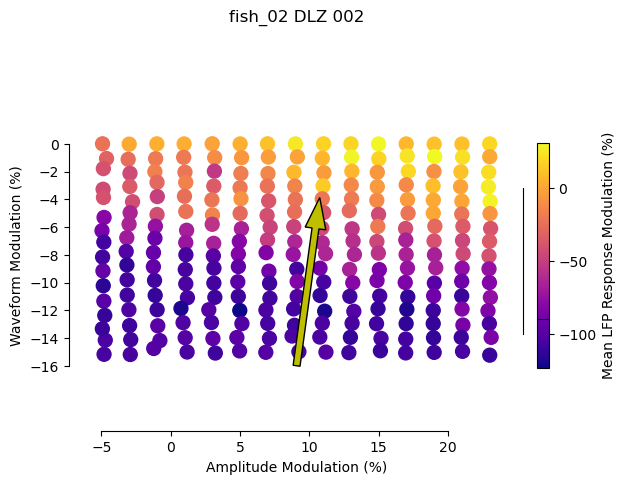

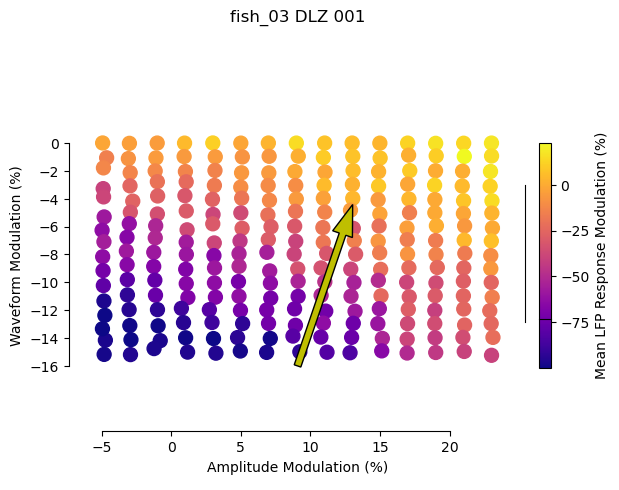

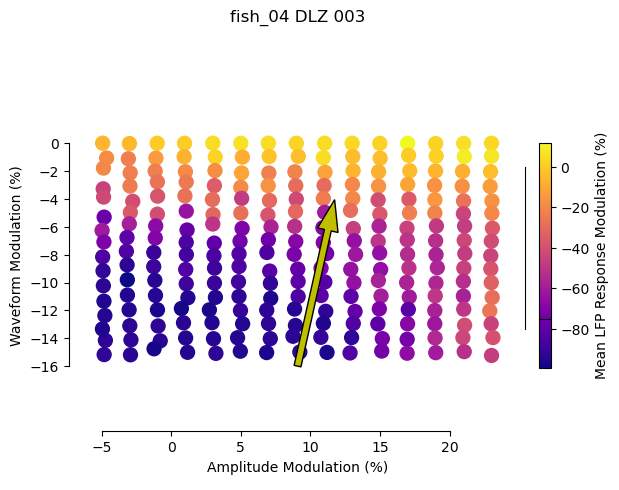

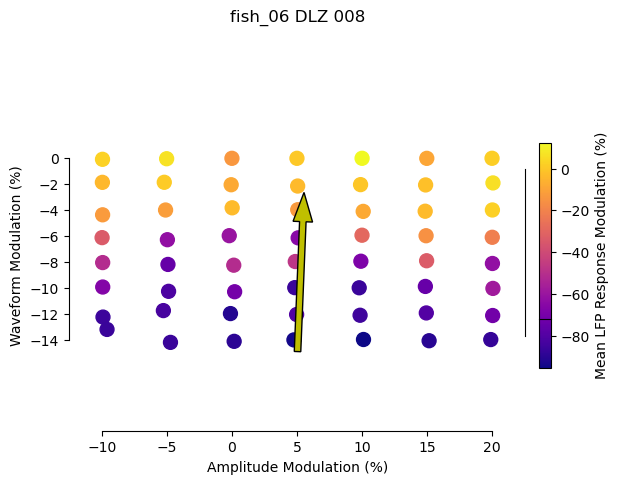

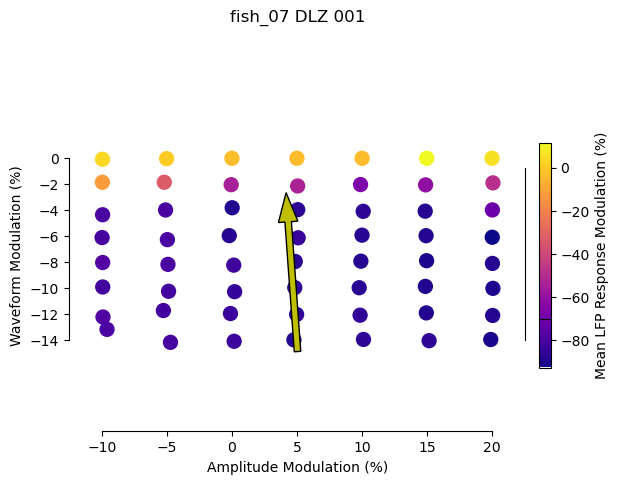

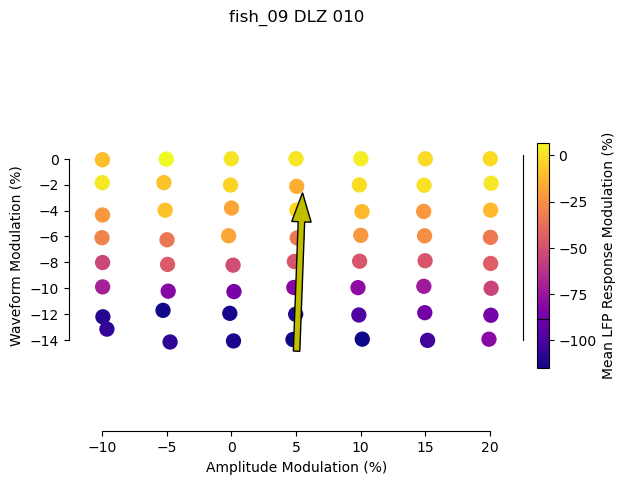

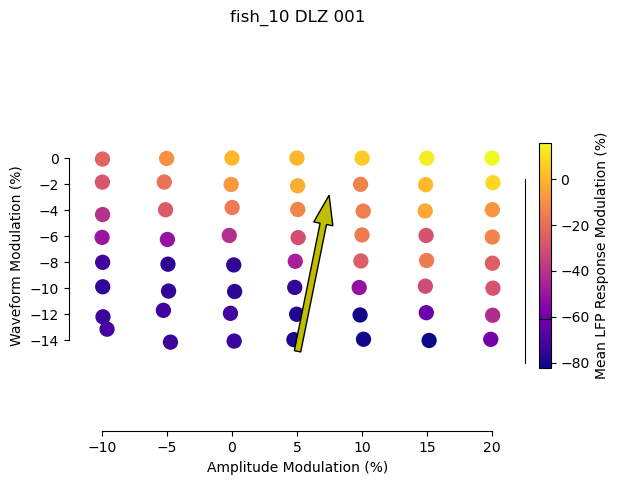

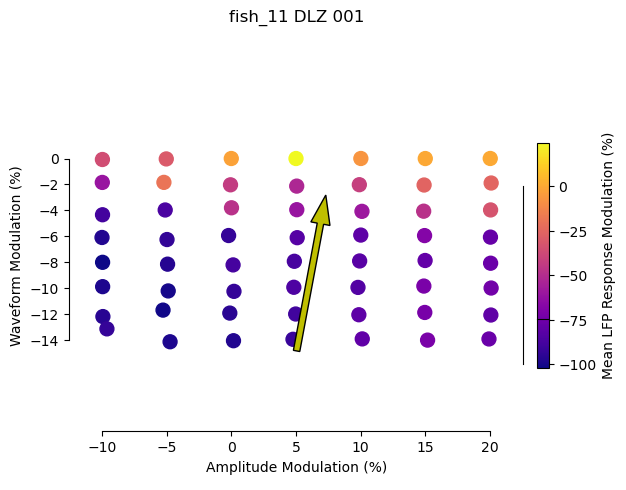

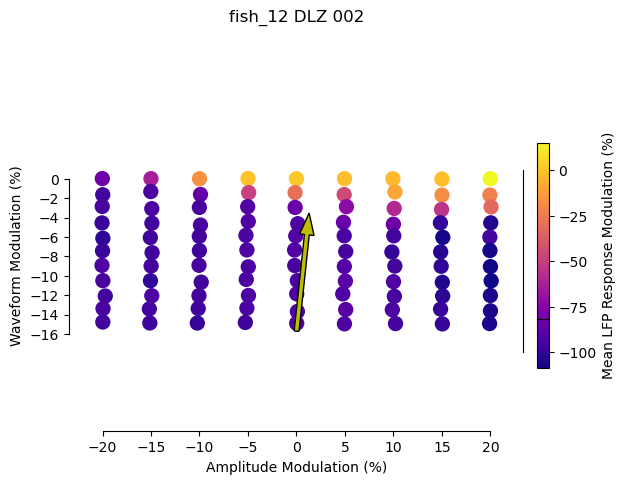

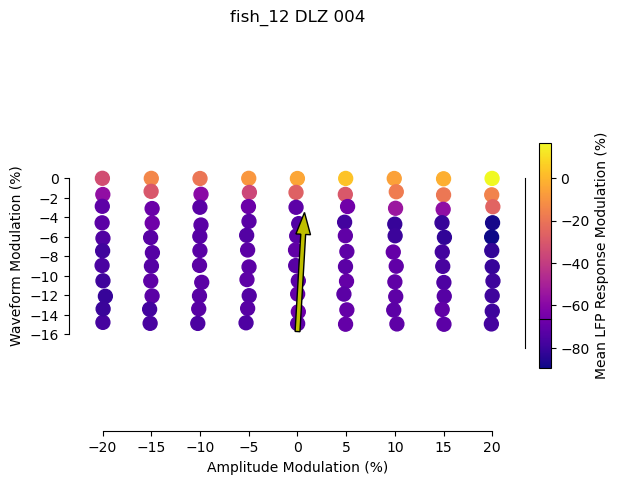

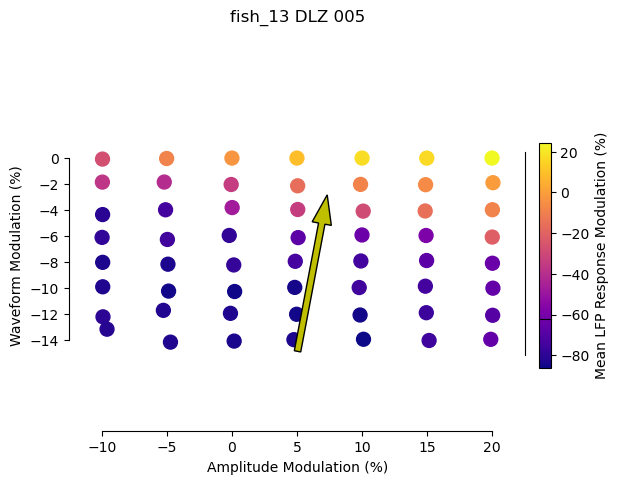

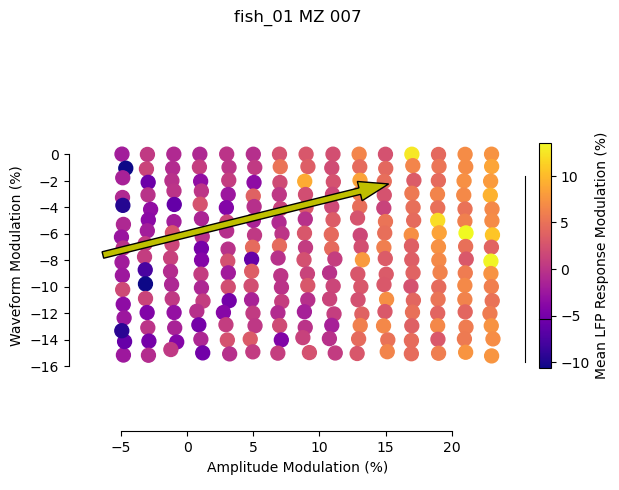

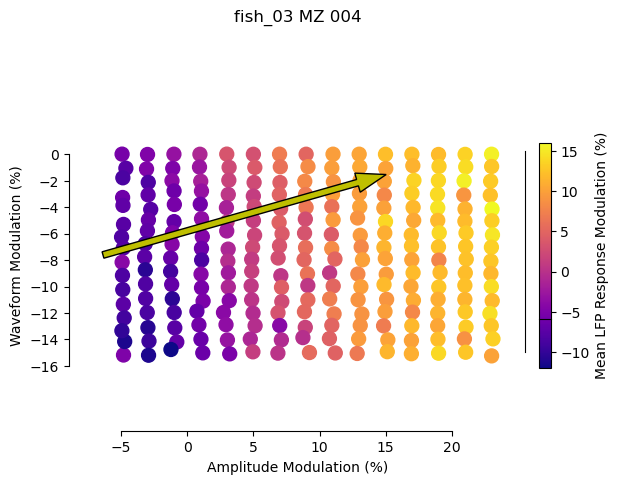

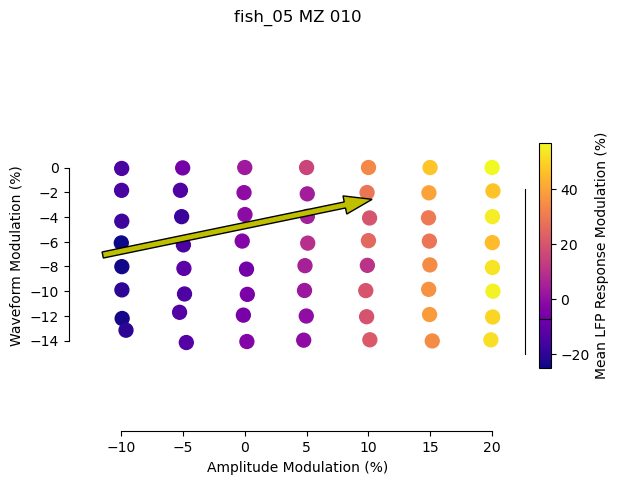

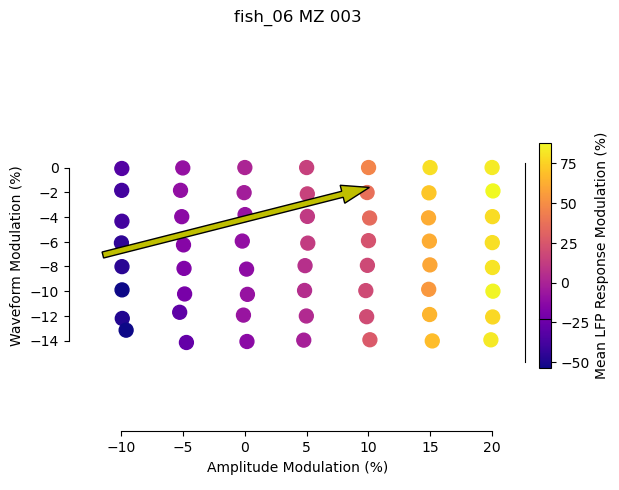

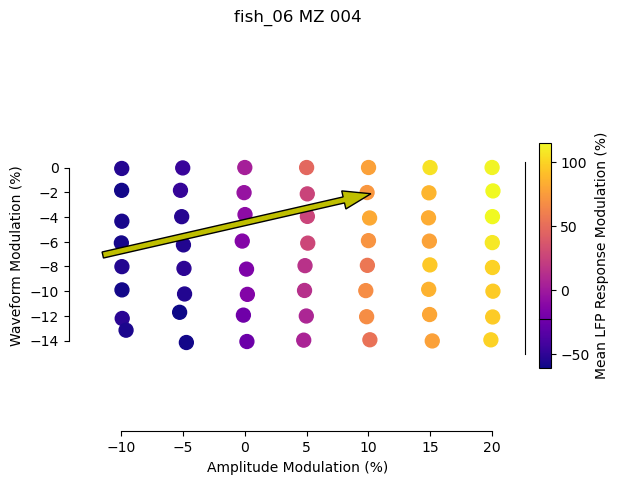

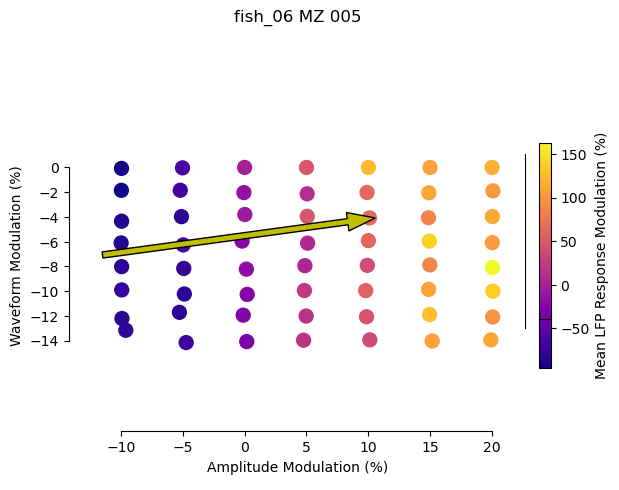

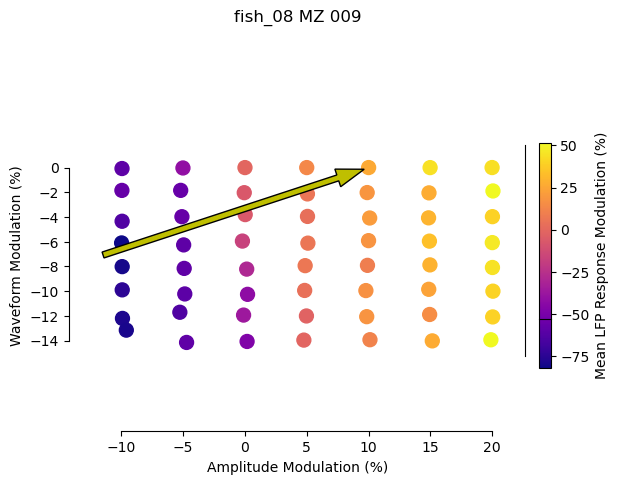

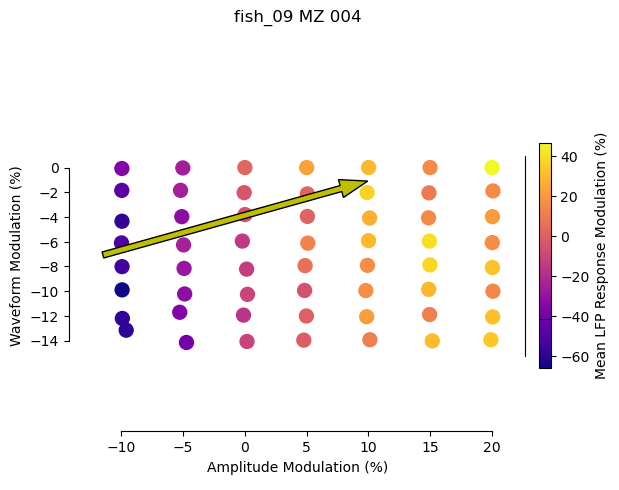

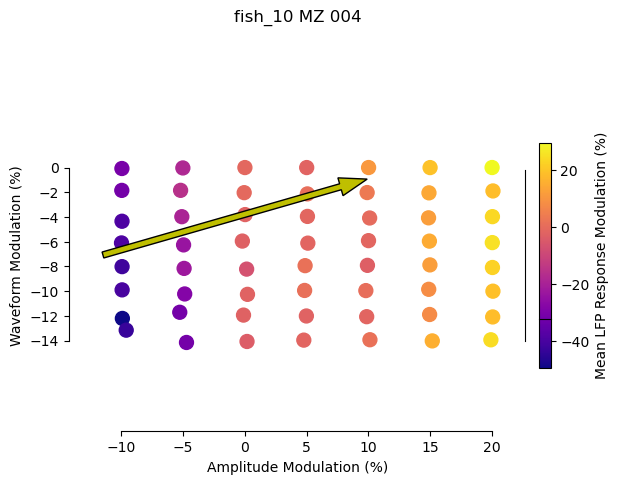

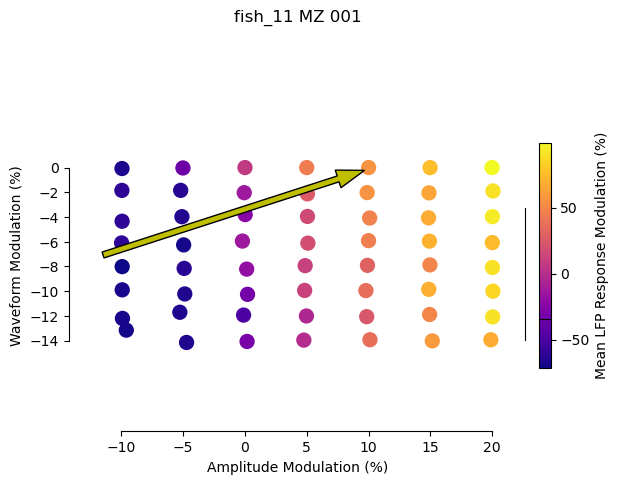

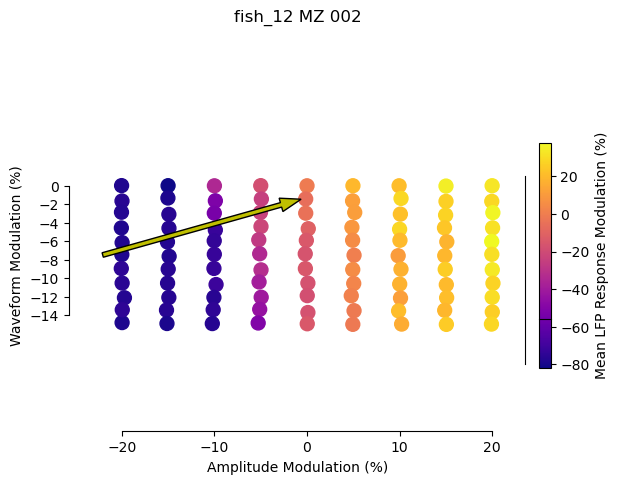

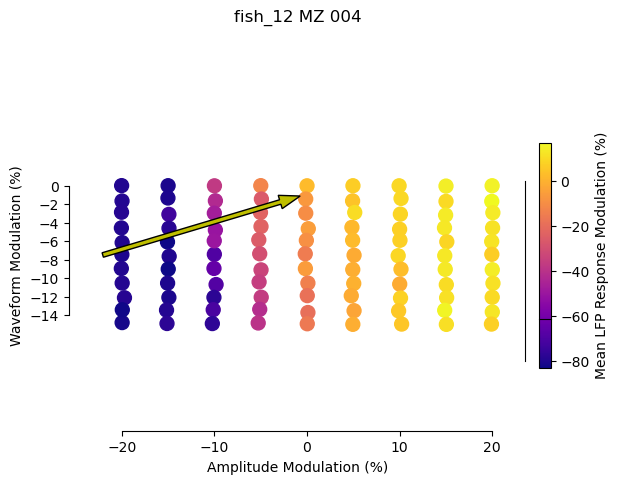

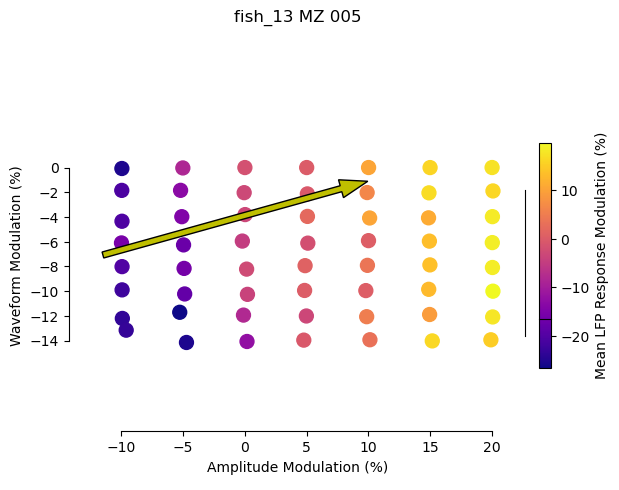

In [12]:
alignment_summary_pppn = lfp_data.groupby(["zone", "fish_id", "session_id"]).apply(plot_alignment_heatmap).reset_index()

In [13]:
alignment_summary_pppn["method"] = "pppn"
alignment_summary_pppn

zone  fish_id session_id  grad_angle  \
0   dlz  fish_01        009   74.067561   
1   dlz  fish_02        002   82.166107   
2   dlz  fish_03        001   71.135014   
3   dlz  fish_04        003   77.435982   
4   dlz  fish_06        008   87.665923   
5   dlz  fish_07        001   94.122832   
6   dlz  fish_09        010   87.852184   
7   dlz  fish_10        001   78.566761   
8   dlz  fish_11        001   79.385635   
9   dlz  fish_12        002   83.936344   
10  dlz  fish_12        004   86.653462   
11  dlz  fish_13        005   79.260923   
12   mz  fish_01        007   13.965872   
13   mz  fish_03        004   15.863770   
14   mz  fish_05        010   11.673071   
15   mz  fish_06        003   14.225906   
16   mz  fish_06        004   12.869599   
17   mz  fish_06        005    7.729770   
18   mz  fish_08        009   18.179055   
19   mz  fish_09        004   15.595778   
20   mz  fish_10        004   16.027213   
21   mz  fish_11        001   17.933993   
22   mz  fish_12        002   15.704937   
23   mz  fish_12        004   16.630872   
24   mz  fish_13        005   15.556828   

                                      grad_vec    reg_r2 method  
0     [0.2745036848883163, 0.9615860476227471]  0.917858   pppn  
1    [0.13630161563291948, 0.9906673859453818]  0.875612   pppn  
2    [0.32333920127753657, 0.9462831293630911]  0.927920   pppn  
3    [0.21753031665992556, 0.9760535647872163]  0.834961   pppn  
4    [0.04072605472878829, 0.9991703500736137]  0.892493   pppn  
5   [-0.07189490824391241, 0.9974122127629075]  0.533832   pppn  
6    [0.03747768578996648, 0.9992974647560297]  0.927416   pppn  
7    [0.19822599078670933, 0.9801563429252639]  0.901129   pppn  
8    [0.18419778949809149, 0.9828891973890123]  0.712076   pppn  
9    [0.10563331142292694, 0.9944051505889473]  0.439319   pppn  
10  [0.058374898500320654, 0.9982947316424529]  0.444487   pppn  
11      [0.1863367423790604, 0.98248593803655]  0.812433   pppn  
12   [0.9704396529642837, 0.24134390391008523]  0.662481   pppn  
13    [0.9619143498563087, 0.2733510262291234]  0.929544   pppn  
14   [0.9793180107240884, 0.20232704681137942]  0.955894   pppn  
15    [0.969334335437374, 0.24574569404606927]  0.967929   pppn  
16   [0.9748795134619277, 0.22273287640632455]  0.965350   pppn  
17   [0.9909134488974507, 0.13450106614506502]  0.941205   pppn  
18    [0.9500861666159951, 0.3119876215572082]  0.945223   pppn  
19    [0.9631823779940875, 0.2688488547895546]  0.846264   pppn  
20   [0.9611306737277896, 0.27609387537496244]  0.903644   pppn  
21    [0.9514118829285029, 0.3079211409150737]  0.964331   pppn  
22    [0.9626684241213599, 0.2706834039975442]  0.939138   pppn  
23    [0.9581685022350884, 0.2862046843162557]  0.898847   pppn  
24    [0.9633649233756543, 0.2681940051705478]  0.946442   pppn

In [14]:
alignment_summary_pppn.groupby("zone").apply(
    lambda x: pd.Series(
        dict(
            angle_mean=x["grad_angle"].mean(),
            angle_std=x["grad_angle"].std(),
            reg_r2_avg=x["reg_r2"].mean(),
            method=x["method"].iloc[0],
        ),
    )
)

angle_mean  angle_std  reg_r2_avg method
zone                                          
dlz    81.854061   6.511642    0.768295   pppn
mz     14.765897   2.795192    0.912792   pppn

## Show PCA from data stimuli

In [15]:
lfp_data = pd.read_pickle('../data/lfp-abby/processed/trial_averages.pkl')
select_stimuli = np.vstack(lfp_data[(lfp_data["fish_id"] == "fish_01") & (lfp_data["zone"] == "mz")]["waveform"]).T
base_stimulus = lfp_data["base_waveform"].iloc[0]
sampling_rate = lfp_data["stimulus_sampling_rate"].iloc[0]

In [16]:
stimuli_pca = PCA().fit(select_stimuli.T)
explained_variance = stimuli_pca.explained_variance_ratio_
components = stimuli_pca.components_[:2]
components[0] = -components[0]
components = components / components.max(1, keepdims=True)

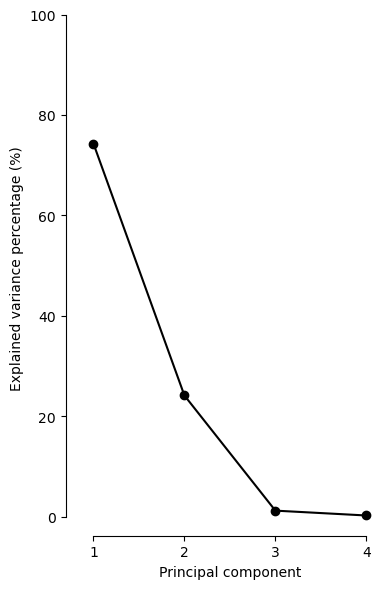

In [17]:
num_comp_to_plot = 4
plt.figure(figsize=(4, 6))
plt.plot(np.arange(num_comp_to_plot).astype(int)+1, explained_variance[:num_comp_to_plot]*100, "k", marker="o")
plt.xlabel("Principal component")
plt.ylabel("Explained variance percentage (%)")
plt.xticks(np.arange(num_comp_to_plot).astype(int)+1)
plt.ylim(-1,100.05)
sns.despine(offset=10, trim=True)
plt.tight_layout()
plt.savefig("./panels/stimuli_pca_explained_variance.svg")
plt.show()

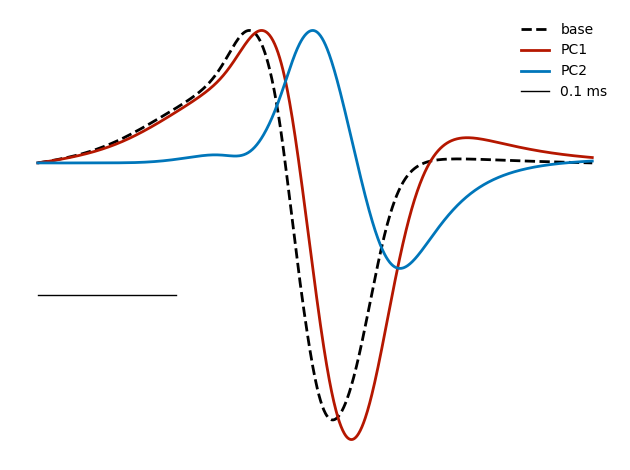

In [18]:
colors = ["#B51700", "#0076BA"]

plt.figure()
plt.plot(base_stimulus / base_stimulus.max(), color="k", ls="--", lw=2)
plt.plot(components[0], color=colors[0], lw=2)
plt.plot(components[1], color=colors[1], lw=2)
plt.plot([0, 0.1e-3 * sampling_rate], [-1, -1], "k", lw=1)
plt.legend(["base", "PC1", "PC2", "0.1 ms"], loc=1, frameon=False)
# plt.plot([0, 0], [-1, -1 + base_stimulus.ptp()/3], "k", lw=1)
plt.xticks([])
plt.yticks([])
plt.box(False)
plt.tight_layout()
plt.savefig("./panels/stimuli_pca_components.svg")
plt.show()

# Receptor Model

In [19]:
filters_models = pd.read_pickle("../filters-models/filters-models-by-fish-zone-session.pkl")

train_errors = filters_models[["input_noise_std", "train_error", "zone"]].copy()
train_errors["error"] = train_errors["train_error"]
train_errors.drop(columns="train_error", inplace=True)
train_errors["set"] = "train"

valid_errors = filters_models[["input_noise_std", "valid_error", "zone"]].copy()
valid_errors["error"] = valid_errors["valid_error"]
valid_errors.drop(columns="valid_error", inplace=True)
valid_errors["set"] = "valid"

filters_models_errors = pd.concat(
    [train_errors, valid_errors],
    axis=0,
    ignore_index=True,
)

## Schematic

Draw the schematic separately in drawing apps.

## Validation error as function of input noise STD

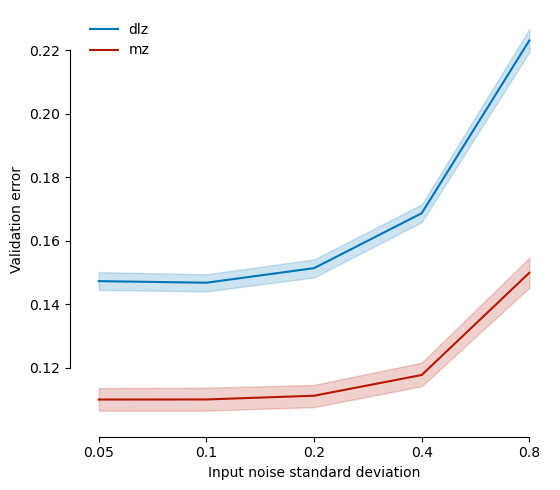

In [26]:
snsplot = sns.relplot(data=valid_errors, x="input_noise_std", y="error", hue="zone", kind="line", palette=dict(mz="#B51700", dlz="#0076BA"))
snsplot.legend.remove()
plt.xlabel("Input noise standard deviation")
plt.ylabel("Validation error")
plt.xscale("log")
plt.legend(loc=2, frameon=False)
plt.minorticks_off()
plt.xticks(valid_errors["input_noise_std"].unique(), valid_errors["input_noise_std"].unique())
sns.despine(offset=5, trim=True)
plt.tight_layout()
plt.savefig("./panels/filters_valid_error_with_input_noise.svg")
plt.show()

## True vs predicted LFP

In [27]:
lfp_data = pd.read_pickle("../data/lfp-abby/processed/single_trials.pkl")
conv_filters = filters_models[filters_models["input_noise_std"] == 0.4]

In [28]:
def compute_single_model_prediction(model_row, waveforms):
    conv_filter = model_row["model_filter"]
    conv_bias = model_row["model_bias"]
    bn_mean = model_row["bn_mean"]
    bn_var = model_row["bn_var"]
    bn_weight = model_row["bn_weight"]
    bn_bias = model_row["bn_bias"]

    responses = (conv_bias + np.dot(waveforms, conv_filter) - bn_mean) / np.sqrt(bn_var + 1e-10) * bn_weight + bn_bias

    return responses


def compute_prediction(dfgroup, conv_filters=conv_filters):
    fish_id = dfgroup["fish_id"].iloc[0]
    zone = dfgroup["zone"].iloc[0]
    waveforms = np.vstack(dfgroup["waveform"])
    best_model_idx = conv_filters[(conv_filters["zone"] == zone) & (conv_filters["fish_id"] == fish_id)][
        "train_error"  # "valid_error"
    ].idxmin()
    modulations = compute_single_model_prediction(conv_filters.loc[best_model_idx], waveforms)
    return modulations

In [29]:
true_values = lfp_data.groupby(["fish_id", "zone"]).apply(lambda x: x["lfp_response_modulation"].to_numpy()).rename("true").reset_index()
predicted_values = (
    lfp_data.groupby(["fish_id", "zone"]).apply(compute_prediction).rename("predicted").reset_index()
)
true_vs_predicted = pd.merge(true_values, predicted_values, on=["fish_id", "zone"])

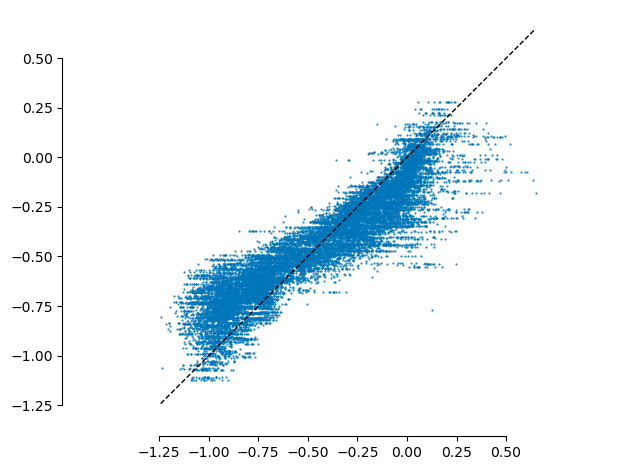

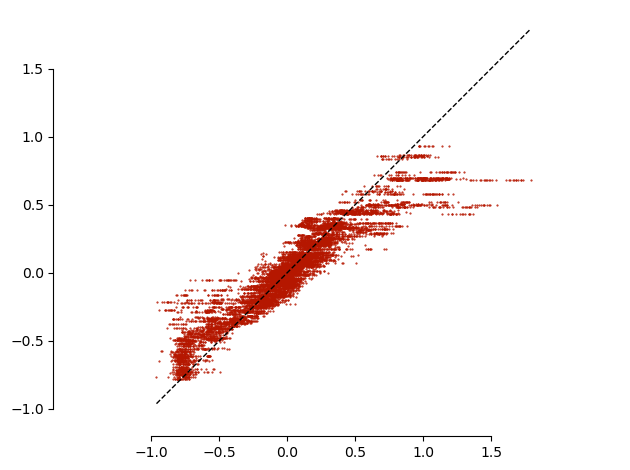

Empty DataFrame
Columns: []
Index: []

In [31]:
def plot_true_vs_predicted(dfgroup, colors=dict(mz="#B51700", dlz="#0076BA")):
    zone = dfgroup["zone"].iloc[0]
    xs = np.hstack(dfgroup["true"])
    ys = np.hstack(dfgroup["predicted"])
    plt.figure()
    plt.scatter(xs, ys, c=colors[zone], s=1, marker=".")
    plt.plot([xs.min(), xs.max()], [xs.min(), xs.max()], "k--", lw=1)
    plt.axis("equal")
    sns.despine(offset=10, trim=True)
    plt.tight_layout()
    plt.savefig(f"./panels/true_vs_predicted_{zone}.svg")
    plt.savefig("./panels/delivered_vs_recorded_scatter.png", dpi=1000)
    plt.show()
    pass


true_vs_predicted.groupby("zone").apply(plot_true_vs_predicted)

## Conv filters

In [32]:
smooth_filters = pd.read_pickle("../data/filters/smooth-filters-all.pkl")
input_noise_std=0.4
sampling_rate = sampling_rate  # defined above

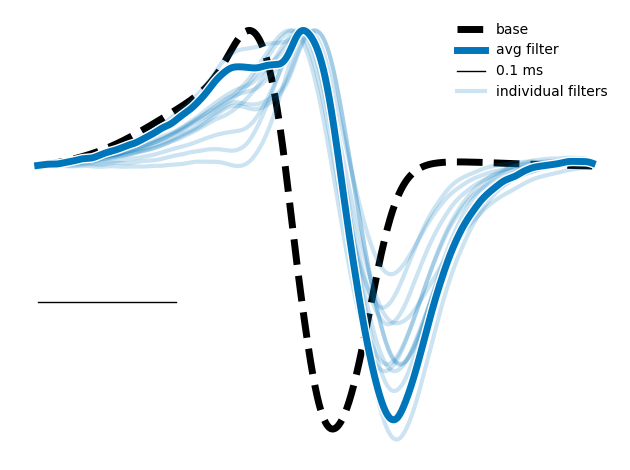

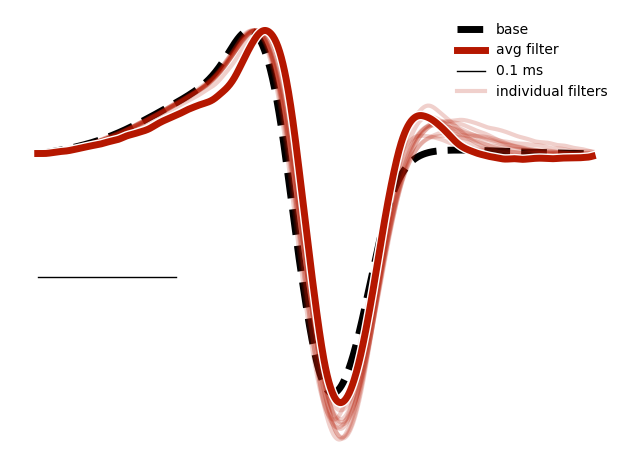

Empty DataFrame
Columns: []
Index: []

In [33]:
def plot_conv_filters(
    dfgroup,
    colors=dict(mz="#B51700", dlz="#0076BA"),
    sampling_rate=sampling_rate,
    base_stimulus=base_stimulus / base_stimulus.max(),
):
    zone = dfgroup["zone"].iloc[0]
    input_noise_std = f"{dfgroup['input_noise_std'].iloc[0]:.2f}".replace(".", "p")
    avg_filter = dfgroup[dfgroup["fish_id"] == "fish"]["model_filter"].iloc[0]
    individual_filters = np.vstack(dfgroup[dfgroup["fish_id"] != "fish"]["model_filter"])

    plt.figure()
    plt.plot(base_stimulus, "k", ls="--", lw=5, zorder=0)
    plt.plot(avg_filter, color=colors[zone], lw=5)
    plt.plot([0, 0.1e-3 * sampling_rate], [-1, -1], "k", lw=1)
    plt.plot(individual_filters.T, color=colors[zone], lw=3, alpha=0.2, zorder=0)
    plt.plot(avg_filter, color="w", lw=7, zorder=1)
    plt.legend(["base", "avg filter", "0.1 ms", "individual filters"], loc=1, frameon=False)
    plt.xticks([])
    plt.yticks([])
    plt.box(False)
    plt.tight_layout()
    plt.savefig(f"./panels/filters_waveform_{zone}_{input_noise_std}.svg")
    if input_noise_std == "0p40":
        plt.show()
    plt.close()
    pass


smooth_filters.groupby(["zone", "input_noise_std"]).apply(plot_conv_filters)

## Alignment with conv. features

In [34]:
lfp_data = pd.read_pickle("../data/lfp-abby/processed/trial_averages.pkl")
cmap = plt.cm.plasma  # type: ignore
conv_filters = filters_models[filters_models["input_noise_std"] == 0.4]

In [35]:
def plot_alignment_heatmap_conv_feats(
    dfgroup, cmap=cmap, inverse_arrow_length=0.1, arrow_width=0.5, conv_filters=conv_filters
):
    fish_id = dfgroup["fish_id"].iloc[0]
    fish_id = dfgroup["fish_id"].iloc[0]
    zone = dfgroup["zone"].iloc[0]
    waveforms = np.vstack(dfgroup["waveform"])
    responses = dfgroup["mean_lfp_response_modulation"] * 100
    color_norm = mpl.colors.Normalize(vmin=responses.min(), vmax=responses.max())  # type: ignore
    if (
        "mz" in conv_filters[conv_filters["fish_id"] == fish_id]["zone"].unique()
        and "dlz" in conv_filters[conv_filters["fish_id"] == fish_id]["zone"].unique()
    ):
        target_angle = 0 if zone == "mz" else 90
        angle_error = np.inf
        conv_filters_mz = conv_filters[(conv_filters["fish_id"] == fish_id) & (conv_filters["zone"] == "mz")]
        conv_filters_dlz = conv_filters[(conv_filters["fish_id"] == fish_id) & (conv_filters["zone"] == "dlz")]
        for i, conv_mz_row in conv_filters_mz.iterrows():
            for j, conv_dlz_row in conv_filters_dlz.iterrows():
                xs = compute_single_model_prediction(conv_mz_row, waveforms) * 100
                ys = compute_single_model_prediction(conv_dlz_row, waveforms) * 100
                reg = LinearRegression().fit(np.stack([xs, ys]).T, responses)
                grad_vec = reg.coef_ / np.linalg.norm(reg.coef_)
                grad_angle = np.arctan2(grad_vec[1], grad_vec[0]) * 360 / (2 * np.pi)
                if np.abs(grad_angle - target_angle) < angle_error:
                    angle_error = np.abs(grad_angle - target_angle)
                    best_model_mz_idx = i
                    best_model_dlz_idx = j

        xs = compute_single_model_prediction(conv_filters.loc[best_model_mz_idx], waveforms) * 100
        ys = compute_single_model_prediction(conv_filters.loc[best_model_dlz_idx], waveforms) * 100
        reg = LinearRegression().fit(np.stack([xs, ys]).T, responses)
        grad_vec = reg.coef_ / np.linalg.norm(reg.coef_)

        fig = plt.figure()
        plt.scatter(xs, ys, c=cmap(color_norm(responses)), s=100, marker="o")
        cbar = fig.colorbar(
            plt.cm.ScalarMappable(norm=color_norm, cmap=cmap),
            ax=plt.gca(),
            shrink=0.5,
            label="Mean LFP Response Modulation (%)",
        )
        sns.despine(ax=cbar.ax, left=False, bottom=False)
        x0, y0 = 0, 0
        if zone == "mz":
            x0 = plt.gca().get_xlim()[0]
            y0 = np.mean(plt.gca().get_ylim())
            inverse_arrow_length /= 2
        elif zone == "dlz":
            x0 = np.mean(plt.gca().get_xlim())
            y0 = plt.gca().get_ylim()[0]
        plt.arrow(
            x0,  # type: ignore
            y0,  # type: ignore
            grad_vec[0] / inverse_arrow_length,
            grad_vec[1] / inverse_arrow_length,
            facecolor="y",
            width=arrow_width,
            edgecolor="k",
            lw=1,
        )
        sns.despine(offset=10, trim=True)
        plt.axis("equal")
        plt.tight_layout()
        plt.title(f"{fish_id} {zone}")
        plt.savefig(f"./panels/response_heatmap_conv_feats-{zone}-{fish_id}.svg")
        plt.show()
        return pd.Series(
            dict(
                grad_angle=np.arctan2(grad_vec[1], grad_vec[0]) * 360 / (2 * np.pi),
                grad_vec=grad_vec,
                reg_r2=reg.score(np.stack([xs, ys]).T, responses),
            )
        )

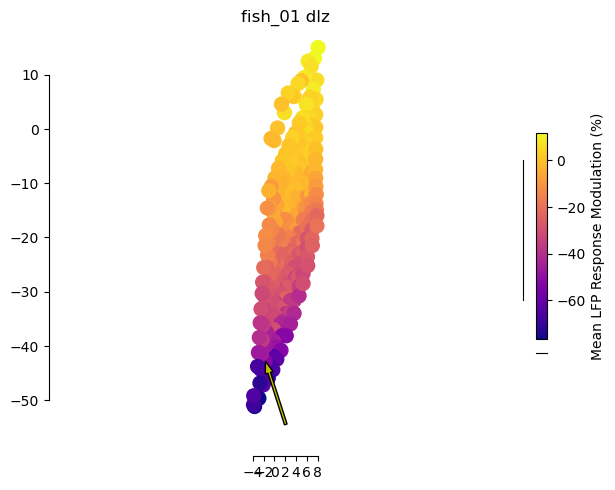

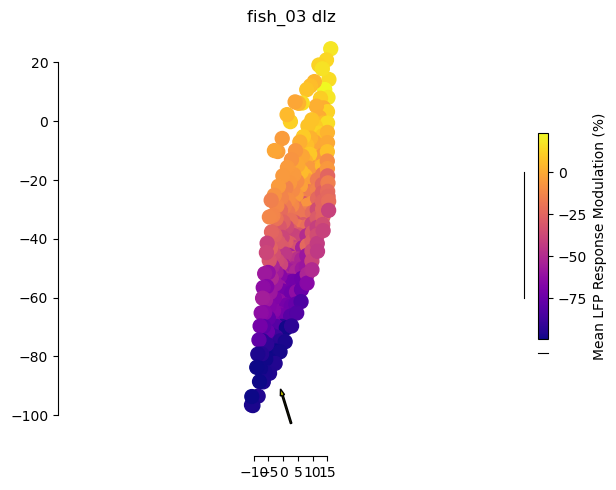

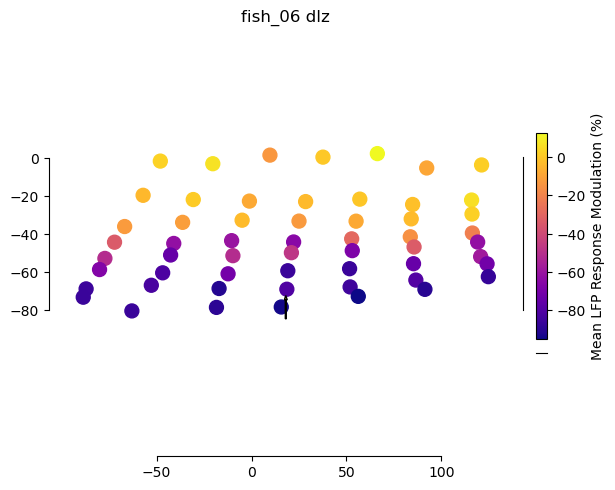

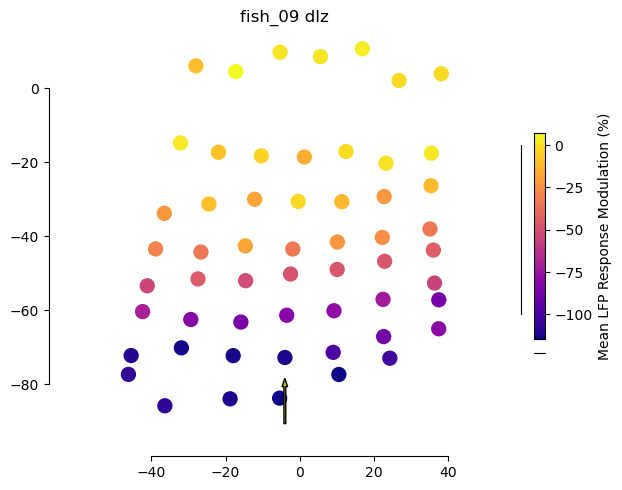

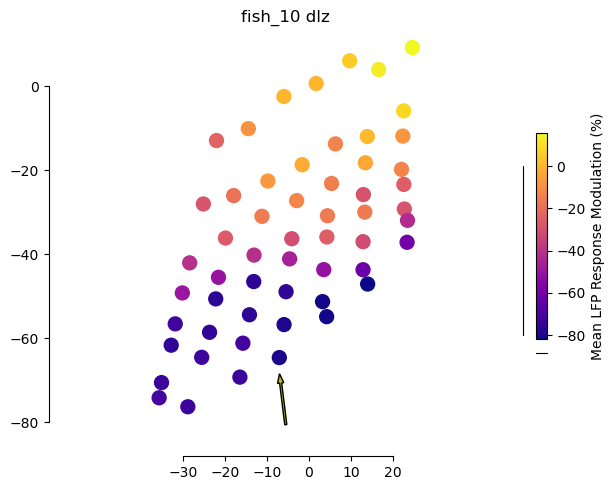

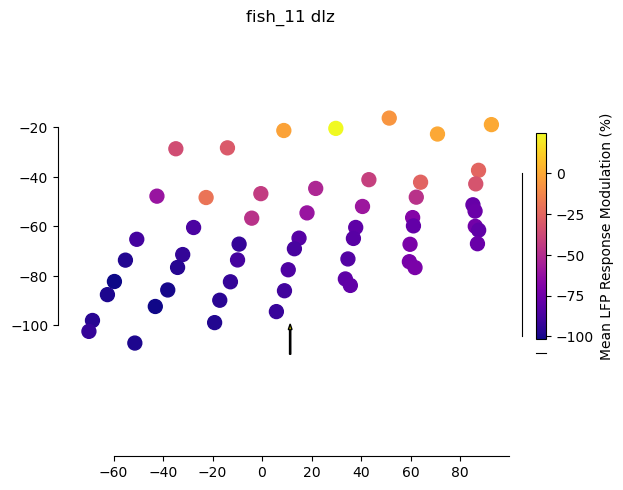

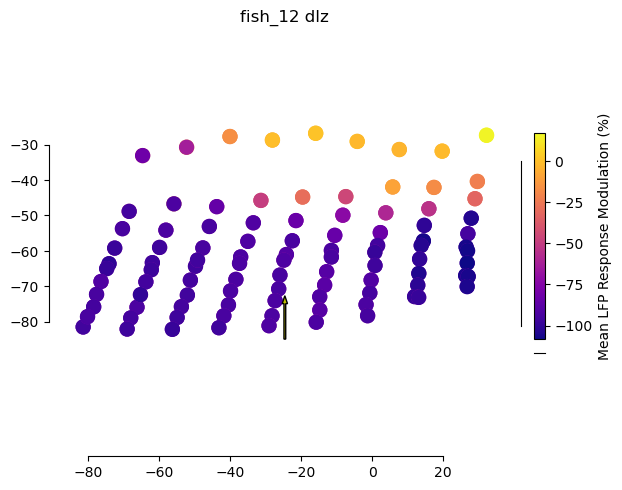

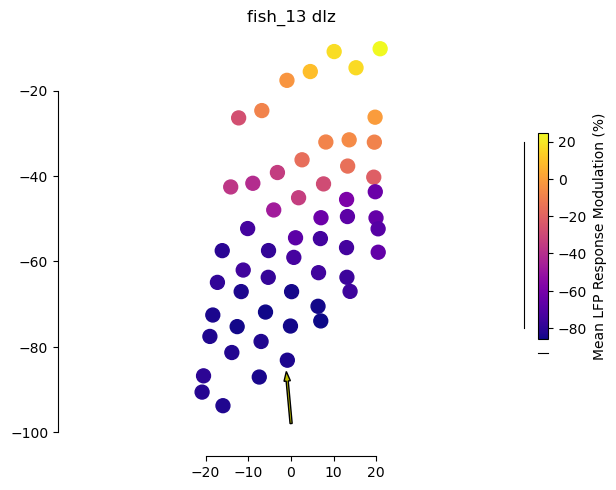

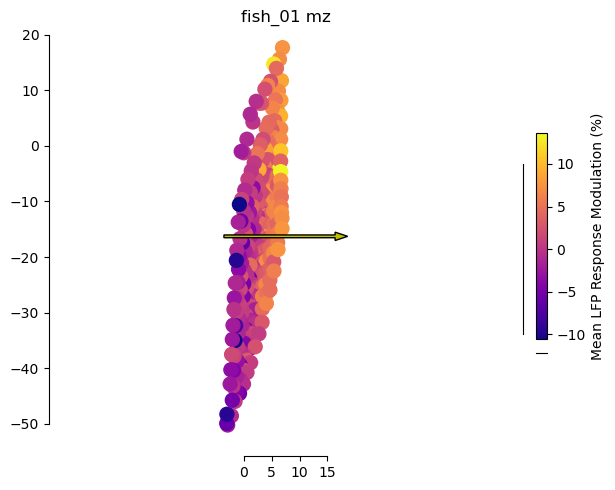

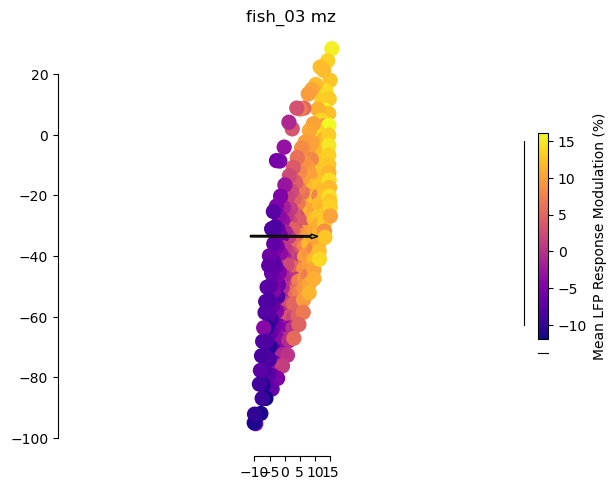

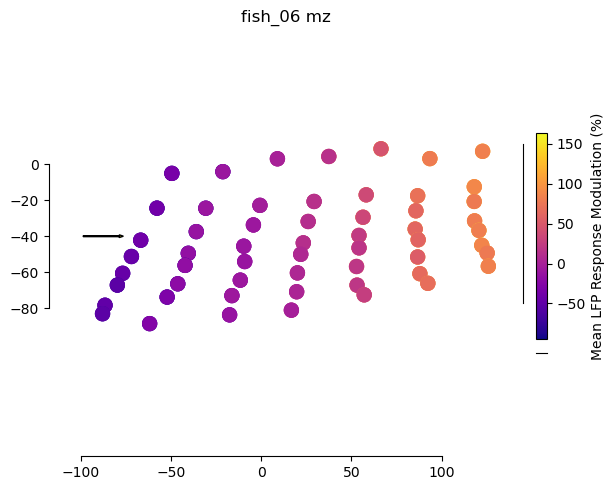

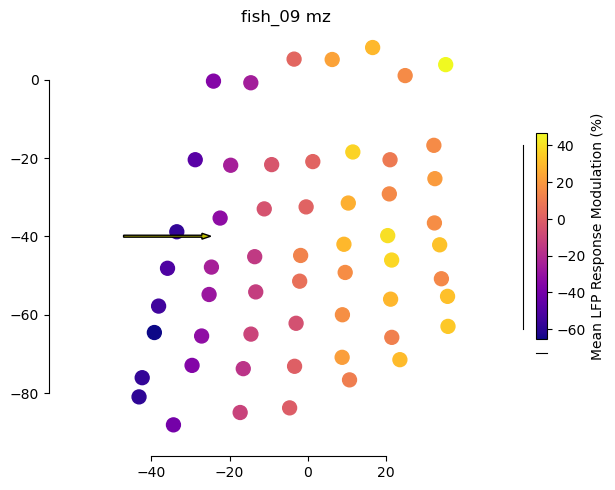

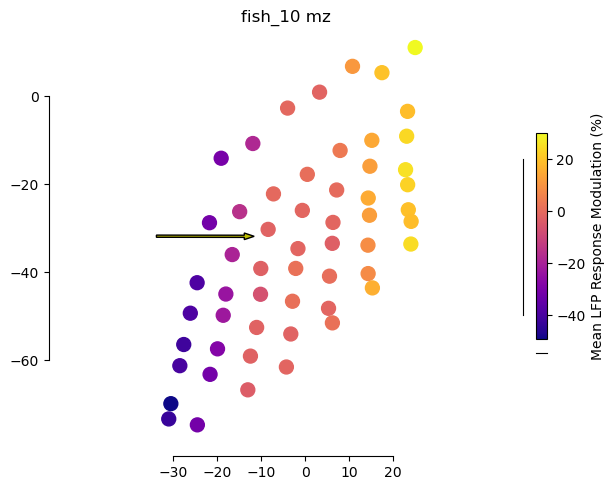

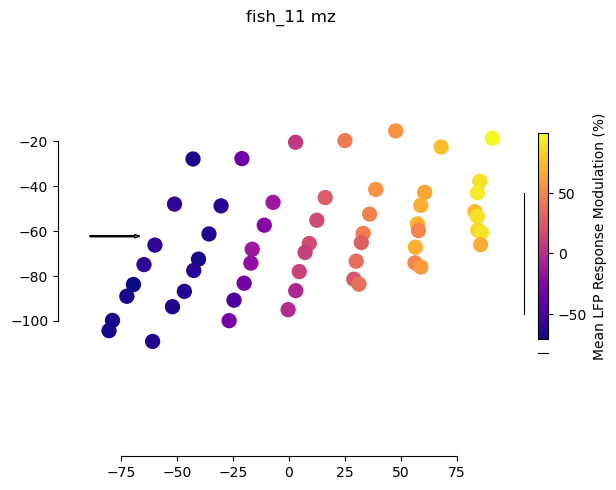

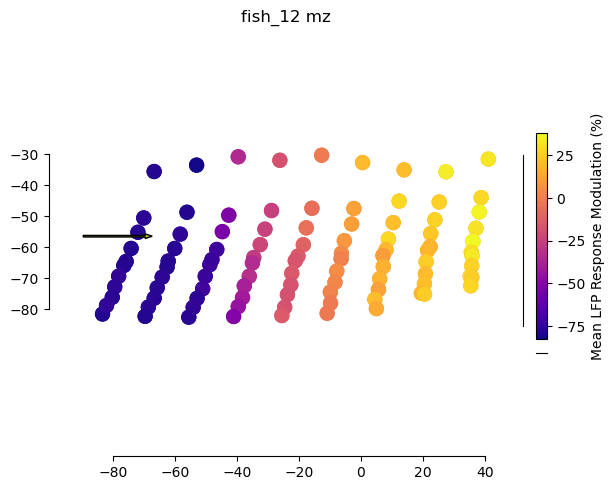

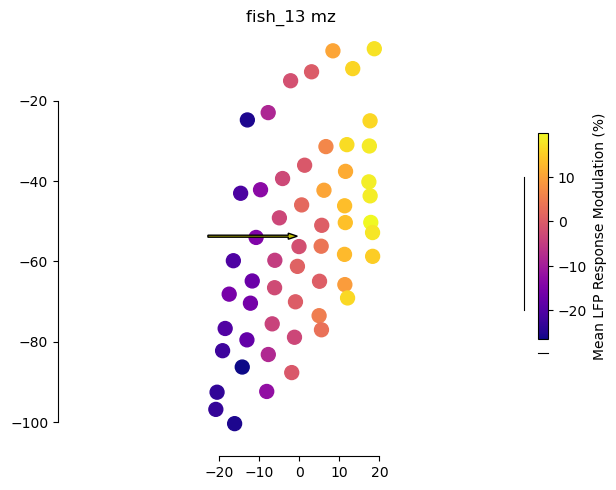

In [36]:
alignment_summary_convfeats = lfp_data.groupby(["zone", "fish_id"]).apply(plot_alignment_heatmap_conv_feats).dropna(axis=0).reset_index()

In [37]:
alignment_summary_convfeats["method"] = "conv_feats"
alignment_summary_convfeats

zone  fish_id  grad_angle                                       grad_vec  \
0   dlz  fish_01  107.817626      [-0.3059881963386072, 0.9520353059112073]   
1   dlz  fish_03  107.113148      [-0.2942596549851203, 0.9557255126070654]   
2   dlz  fish_06   90.000360  [-6.2911345335799935e-06, 0.9999999999802109]   
3   dlz  fish_09   90.003144  [-5.4871985599913184e-05, 0.9999999984945326]   
4   dlz  fish_10   97.036496     [-0.12250154436469506, 0.9924683227329045]   
5   dlz  fish_11   90.025715  [-0.00044881126025608775, 0.9999998992842213]   
6   dlz  fish_12   90.012276  [-0.00021425388743867612, 0.9999999770476357]   
7   dlz  fish_13   95.265737     [-0.09177512554587038, 0.9957797579440144]   
8    mz  fish_01   -0.000761  [0.9999999999118987, -1.3274132431799217e-05]   
9    mz  fish_03   -0.182013    [0.9999949542324406, -0.003176713657088031]   
10   mz  fish_06    0.003047      [0.99999999858561, 5.318627771210227e-05]   
11   mz  fish_09   -0.012116  [0.9999999776400426, -0.00021147083544890264]   
12   mz  fish_10   -0.072420    [0.999999201199574, -0.0012639621093779414]   
13   mz  fish_11   -0.001352  [0.9999999997213893, -2.3605541393036618e-05]   
14   mz  fish_12   -0.000029   [0.9999999999998743, -5.015284700405387e-07]   
15   mz  fish_13   -0.000134  [0.9999999999972723, -2.3357143949701634e-06]   

      reg_r2      method  
0   0.896611  conv_feats  
1   0.927274  conv_feats  
2   0.832047  conv_feats  
3   0.855482  conv_feats  
4   0.858993  conv_feats  
5   0.797483  conv_feats  
6   0.517839  conv_feats  
7   0.839717  conv_feats  
8   0.657833  conv_feats  
9   0.926604  conv_feats  
10  0.896203  conv_feats  
11  0.858751  conv_feats  
12  0.911086  conv_feats  
13  0.959050  conv_feats  
14  0.911541  conv_feats  
15  0.948977  conv_feats

In [38]:
alignment_summary_convfeats.groupby("zone").apply(
    lambda x: pd.Series(
        dict(
            angle_mean=x["grad_angle"].mean(),
            angle_std=x["grad_angle"].std(),
            reg_r2_avg=x["reg_r2"].mean(),
            method=x["method"].iloc[0],
        )
    )
)

angle_mean  angle_std  reg_r2_avg      method
zone                                               
dlz    95.909313   7.636462    0.815681  conv_feats
mz     -0.033222   0.065139    0.883756  conv_feats

## Alignment summary plot

In [39]:
alignment_summary = pd.concat([alignment_summary_pppn, alignment_summary_convfeats], axis=0, names=["pppn", "convfeats"], ignore_index=True)

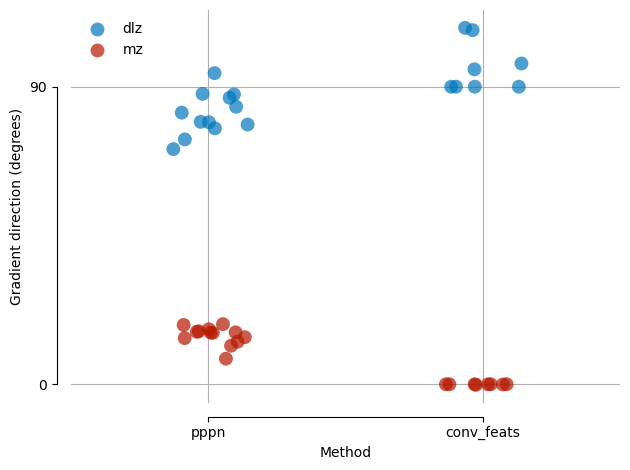

In [40]:
f = plt.figure()
colors = ["#B51700", "#0076BA"]
sns.stripplot(
    data=alignment_summary,
    x="method",
    y="grad_angle",
    hue="zone",
    s=10,
    alpha=0.7,
    palette=dict(mz="#B51700", dlz="#0076BA"),
    dodge=False,
    jitter=0.15,
)
plt.yticks([0, 90])
plt.legend(loc=2, frameon=False)
plt.xlabel("Method")
plt.ylabel("Gradient direction (degrees)")
plt.grid(True)
sns.despine(offset=10, trim=True)
plt.tight_layout()
plt.savefig("./panels/alignment_summary_scatter.svg")
plt.show()

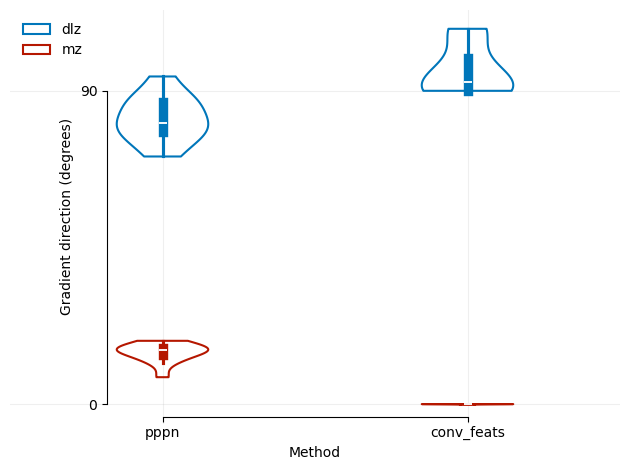

In [41]:
f = plt.figure()
colors = ["#B51700", "#0076BA"]
sns.violinplot(
    data=alignment_summary,
    x="method",
    y="grad_angle",
    hue="zone",
    palette=dict(mz="#B51700", dlz="#0076BA"),
    cut=0,
    split=False,
    inner="box",
    fill=False,
    dodge=False,
    width=0.3,
    density_norm="width",
)
plt.yticks([0, 90])
plt.legend(loc=2, frameon=False)
plt.xlabel("Method")
plt.ylabel("Gradient direction (degrees)")
sns.despine(offset=dict(left=-70, bottom=-5), trim=True)
plt.grid(True, alpha=0.2, zorder=-1)
plt.gca().set_axisbelow(True)
plt.tight_layout()
plt.savefig("./panels/alignment_summary_violin.svg")
plt.show()

## Adaptation panel

In [61]:
# select a model
filters_models = pd.read_pickle("../filters-models/filters-models-by-fish-zone-session.pkl")
model_idx = filters_models[
    (filters_models["input_noise_std"] == 0.4) & (filters_models["zone"] == "mz")
].valid_error.idxmin()
model_row = filters_models.loc[model_idx]
model_path = f"../filters-models/trained-by-fish-zone-session/{model_row['fish_id']}-{model_row['zone']}-{model_row['session_id']}-{str(model_row['input_noise_std']).replace('.','p')}/version_{model_row['model_id']}/checkpoints/*"
model_path = glob.glob(model_path)
assert len(model_path) == 1, "there should be only one model file"
model_path = model_path[0]
model = ConvMormyromast(
    input_length=base_stimulus.shape[0],
    input_channels=1,
    conv_layer_fraction_widths=[1],
    conv_output_channels=1,
    conv_stride=25,
    N_receptors=1,
)
model_state_dict = torch.load(model_path, map_location=torch.device("cpu"))["state_dict"]
new_model_state_dict = {}
for k, v in model_state_dict.items():
    new_model_state_dict[k[6:]] = v
model.load_state_dict(new_model_state_dict)
model.init_adaptation_values_from_BatchNorm()
model.adapt_coeff = (1-0.9997) / 2
model.eval()

# load the data
lfp_data = pd.read_pickle("../data/lfp-abby/processed/single_trials.pkl")
lfp_data = create_train_and_validation_datasets(
    lfp_data, fish_id=model_row["fish_id"], zone=model_row["zone"], session_id=model_row["session_id"], percent_train=1
)
lfp_data_loader = DataLoader(lfp_data, batch_size=100, shuffle=True, drop_last=True)
errors = []
for i in range(100):
    xs, ys = next(iter(lfp_data_loader))
    ys = ys.numpy().flatten()
    if i >= 60:
        xs = xs * 2
    elif i >= 20:
        xs = xs / 2
    
    with torch.no_grad():
        predictions = model(xs, mode="adaptive").detach().cpu().numpy().flatten()
    errors.append(predictions - ys)
    # errors.append(np.abs(predictions - ys))
errors = np.hstack(errors)

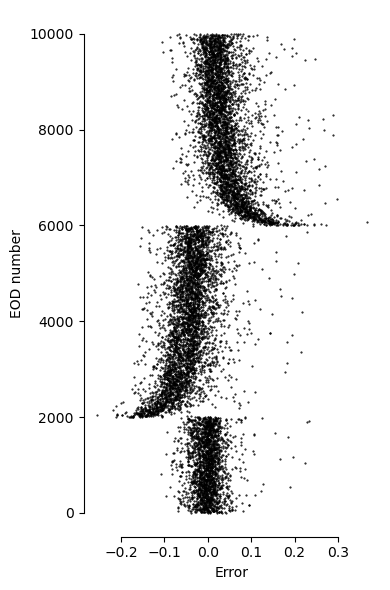

In [62]:
plt.figure(figsize=(4, 6))
plt.scatter(errors, np.arange(errors.shape[0]) + 1, c="k", marker=".", s=1)
plt.xlabel("Error")
plt.ylabel("EOD number")
sns.despine(offset=0, trim=True)
plt.tight_layout()
plt.savefig("./panels/adaptation.svg")
plt.show()

# Miscellaneous

## inspect gradient direction in alignment plots

In [63]:
lfp_data = pd.read_pickle("../data/lfp-abby/processed/trial_averages.pkl")
fish_id = "fish_01"
zone = "dlz"
dfgroup = lfp_data[(lfp_data["fish_id"] == fish_id) & (lfp_data["zone"] == zone)]
waveforms = np.vstack(dfgroup["waveform"])
conv_filters = filters_models[filters_models["input_noise_std"] == 0.4]

best_model_mz_idx = conv_filters[(conv_filters["fish_id"] == fish_id) & (conv_filters["zone"] == "mz")][
    "valid_error"
].idxmin()
best_model_dlz_idx = conv_filters[(conv_filters["fish_id"] == fish_id) & (conv_filters["zone"] == "dlz")][
    "valid_error"
].idxmin()
xs = compute_single_model_prediction(conv_filters.loc[best_model_mz_idx], waveforms) * 100
ys = compute_single_model_prediction(conv_filters.loc[best_model_dlz_idx], waveforms) * 100

responses = dfgroup["mean_lfp_response_modulation"] * 100
reg = LinearRegression().fit(np.stack([xs, ys]).T, responses)
grad_vec = reg.coef_ / np.linalg.norm(reg.coef_)
print(grad_vec, np.arctan2(grad_vec[1], grad_vec[0]) * 360 / (2 * np.pi), reg.score(np.stack([xs, ys]).T, responses))

fig = px.scatter_3d(x=xs, y=ys, z=responses, color=responses, opacity=0.5)
fig.update_traces(marker_size = 5)
fig.update_layout(width=500, height=500)
fig.show()

[-0.49984072  0.86611734] 119.98946280387588 0.8963571335799561


In [64]:
responses = ys
reg2 = LinearRegression().fit(np.stack([xs, ys]).T, responses)
grad_vec = reg2.coef_ / np.linalg.norm(reg2.coef_)
print(grad_vec, np.arctan2(grad_vec[1], grad_vec[0]) * 360 / (2 * np.pi), reg2.score(np.stack([xs, ys]).T, responses))

fig = px.scatter_3d(x=xs, y=ys, z=responses, color=responses, opacity=0.5)
fig.update_traces(marker_size = 5)
fig.update_layout(width=500, height=500)
fig.show()

[-1.30164141e-15  1.00000000e+00] 90.00000000000007 1.0
